# ==========================================================
# Script para detecção de outliers com Random Forest, Extratree, GradienteBuster e MPL (Perceptron Multicamadas - RNA)
# Versão com multiplas nuvens de pontos: x y z label
# Versão utilizando estatísticas locais e dentro de um cilindro
# Versão com validação do modelo ao final do treinamento
# ===========================================================

In [ ]:
# ---------------------------------------------------------
!pip install scikit-learn pandas numpy matplotlib tqdm --quiet

import os
import io
import numpy as np
import pandas as pd
from google.colab import files
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [ ]:
# -----------------------------
# Configurações
# -----------------------------
K_NEIGHBORS = 20            # número de vizinhos para features locais (em XY)
R_FACTOR = 3.0             # R = R_FACTOR * median(nn_distances_in_XY)
MIN_POINTS_FOR_CYL = 5     # mínimo de vizinhos no cilindro para calcular estatísticas
TEST_SIZE = 0.2
RANDOM_STATE = 42
PLOT_SHOW = True           # mostrar plots inline
SAVE_PLOTS = True          # salvar arquivos de figura
OUT_FOLDER = "results_pipeline"
os.makedirs(OUT_FOLDER, exist_ok=True)

# -----------------------------
# Leitura flexível de um arquivo:
# aceita header (x y z label) ou sem header (3/4 colunas)
# retorna df padronizado com colunas: x, y, z, label
# -----------------------------
def read_pointcloud_flexible(path_or_bytes, name_for_errors="file"):
    """
    path_or_bytes: caminho ou bytes (quando usando files.upload)
    """
    # tenta ler com header
    try:
        if isinstance(path_or_bytes, (bytes, bytearray)):
            df_try = pd.read_csv(io.BytesIO(path_or_bytes), sep=r"\s+", engine="python")
        else:
            df_try = pd.read_csv(path_or_bytes, sep=r"\s+", engine="python")
        cols_low = [c.strip().lower() for c in df_try.columns]
        if set(["x","y","z","label"]).issubset(cols_low):
            # padroniza ordem e nomes
            mapping = {orig: low for orig, low in zip(df_try.columns, cols_low)}
            df_try = df_try.rename(columns=mapping)
            df = df_try[["x","y","z","label"]].copy()
            df[['x','y','z']] = df[['x','y','z']].astype(float)
            df['label'] = df['label'].astype(int)
            return df
        # caso header presente mas nomes diferente, tenta forçar por posição:
        if df_try.shape[1] >= 4:
            df_try = df_try.iloc[:, :4]
            df_try.columns = ['x','y','z','label']
            df_try[['x','y','z']] = df_try[['x','y','z']].astype(float)
            df_try['label'] = df_try['label'].astype(int)
            return df_try
        # se tem exatamente 3 colunas e header era texto (ex: 'x y z'), é OK:
        if df_try.shape[1] == 3:
            df_try.columns = ['x','y','z']
            df_try['label'] = 0
            df_try[['x','y','z']] = df_try[['x','y','z']].astype(float)
            return df_try
    except Exception as e:
        # tenta leitura sem header (forçando nomes)
        pass

    # fallback: ler sem header e atribuir colunas
    try:
        if isinstance(path_or_bytes, (bytes, bytearray)):
            df = pd.read_csv(io.BytesIO(path_or_bytes), sep=r"\s+", header=None, engine="python")
        else:
            df = pd.read_csv(path_or_bytes, sep=r"\s+", header=None, engine="python")
        if df.shape[1] >= 4:
            df = df.iloc[:, :4]
            df.columns = ['x','y','z','label']
        elif df.shape[1] == 3:
            df.columns = ['x','y','z']
            df['label'] = 0
        else:
            raise ValueError(f"{name_for_errors}: arquivo com número inesperado de colunas ({df.shape[1]})")
        df[['x','y','z']] = df[['x','y','z']].astype(float)
        df['label'] = df['label'].fillna(0).astype(int)
        return df
    except Exception as e:
        raise ValueError(f"Falha ao ler {name_for_errors}: {e}")

# -----------------------------
# Feature extraction por nuvem
# - vizinhança selecionada em XY (NearestNeighbors usando XY)
# - covariância usando pontos 3D para curvatura
# - raio R adaptativo = R_FACTOR * median(nn_distances_xy)
# Retorna df com colunas de features (mantém x,y,z,label originais)
# -----------------------------
def extract_features_for_cloud(df, k_neighbors=K_NEIGHBORS, r_factor=R_FACTOR):
    pts = df[['x','y','z']].values
    pts_xy = df[['x','y']].values

    N = len(df)
    # --- nearest neighbors in XY to compute typical spacing ---
    nbrs_xy = NearestNeighbors(n_neighbors=min(k_neighbors+1, N), algorithm='auto').fit(pts_xy)
    dists_xy_all, idxs_xy_all = nbrs_xy.kneighbors(pts_xy)
    # remove self (first column distance zero)
    dists_nn = dists_xy_all[:, 1] if dists_xy_all.shape[1] > 1 else dists_xy_all[:, 0]
    median_nn = np.median(dists_nn)
    R = max(1e-6, r_factor * median_nn)  # raio adaptativo (evita zero)

    # para features locais usamos k neighbors (em XY), mas para cov usamos os mesmos vizinhos em 3D
    k_use = min(k_neighbors+1, N)
    nbrs_xy_k = NearestNeighbors(n_neighbors=k_use, algorithm='auto').fit(pts_xy)
    dists_k, idxs_k = nbrs_xy_k.kneighbors(pts_xy)  # includes self as first neighbor

    # inicializa listas
    densidade = np.zeros(N)
    dist_media = np.zeros(N)
    curvatura = np.zeros(N)
    linearidade = np.zeros(N)
    planaridade = np.zeros(N)
    rugosidade = np.zeros(N)
    declividade = np.zeros(N)

    for i in range(N):
        idxs = idxs_k[i]
        # remove self index (geralmente primeiro)
        idxs_n = idxs[idxs != i]
        viz = pts[idxs_n] if len(idxs_n)>0 else pts[idxs]
        densidade[i] = len(viz)
        dist_media[i] = np.mean(np.linalg.norm(viz - pts[i], axis=1)) if len(viz)>0 else 0.0

        # covariancia em 3D (inclui Z)
        if len(viz) >= 3:
            cov = np.cov(viz.T)
            eigvals, _ = np.linalg.eigh(cov)
            eigvals = np.sort(np.maximum(eigvals, 0))  # evita negativos numericos
            s = eigvals.sum()
            if s > 0:
                curvatura[i] = eigvals[0] / s
                linearidade[i] = (eigvals[2] - eigvals[1]) / eigvals[2] if eigvals[2] > 0 else 0
                planaridade[i] = (eigvals[1] - eigvals[0]) / eigvals[2] if eigvals[2] > 0 else 0
            else:
                curvatura[i] = linearidade[i] = planaridade[i] = 0.0
        else:
            curvatura[i] = linearidade[i] = planaridade[i] = 0.0

        # rugosidade: desv padrao em Z dos vizinhos (3D)
        rugosidade[i] = np.std(viz[:,2]) if len(viz)>0 else 0.0

        # declividade média: inclinação relativa aos vizinhos
        delta_z = viz[:,2] - pts[i,2] if len(viz)>0 else np.array([0.0])
        delta_xy = np.linalg.norm(viz[:,:2] - pts[i,:2], axis=1) if len(viz)>0 else np.array([0.0])
        slope_deg = np.degrees(np.mean(np.arctan2(np.abs(delta_z), delta_xy + 1e-8)))
        declividade[i] = slope_deg

    # --- Estatísticas dentro do cilindro de raio R (em XY) ---
    dens_cil = np.zeros(N)
    dist_cil = np.zeros(N)
    curv_cil = np.zeros(N)
    for i in range(N):
        # calcula distancias horizontais em XY
        dxy = np.linalg.norm(pts_xy - pts_xy[i], axis=1)
        mask = dxy < R
        pts_mask = pts[mask]
        if pts_mask.shape[0] < MIN_POINTS_FOR_CYL:
            dens_cil[i] = 0
            dist_cil[i] = 0
            curv_cil[i] = 0
            continue
        dens_cil[i] = pts_mask.shape[0]
        dist_cil[i] = np.mean(np.linalg.norm(pts_mask - pts[i], axis=1))
        cov = np.cov(pts_mask.T)
        eigvals, _ = np.linalg.eigh(cov)
        eigvals = np.sort(np.maximum(eigvals, 0))
        s = eigvals.sum()
        curv_cil[i] = eigvals[0] / s if s>0 else 0.0

    # monta dataframe de features
    features_df = pd.DataFrame({
        'x': df['x'].values,
        'y': df['y'].values,
        'z': df['z'].values,
        'label': df['label'].values,
        'densidade': densidade,
        'dist_media': dist_media,
        'curvatura': curvatura,
        'linearidade': linearidade,
        'planaridade': planaridade,
        'rugosidade': rugosidade,
        'declividade': declividade,
        'densidade_cilindro': dens_cil,
        'dist_media_cilindro': dist_cil,
        'curvatura_cilindro': curv_cil,
        'R_used': R  # mesmo valor para toda a nuvem
    })
    return features_df


In [ ]:
# -----------------------------
# Upload múltiplo ou lista manual
# -----------------------------
print("Faça upload de 1+ arquivos (.txt) contendo x y z label (com ou sem cabeçalho).")
uploaded = files.upload()
file_names = list(uploaded.keys())
# --- Se preferir, você pode substituir 'file_names' por uma lista local, ex:
# file_names = ["plano.txt", "sela.txt"]


Faça upload de 1+ arquivos (.txt) contendo x y z label (com ou sem cabeçalho).


Saving superficie_onda_ruido.txt to superficie_onda_ruido.txt
Saving superficie_pico_ruido.txt to superficie_pico_ruido.txt
Saving superficie_pico_suavizada_ruido.txt to superficie_pico_suavizada_ruido.txt
Saving superficie_plano_ruido.txt to superficie_plano_ruido.txt
Saving superficie_sela_ruido.txt to superficie_sela_ruido.txt


In [ ]:
# -----------------------------
# Extrair features por arquivo, e armazenar
# -----------------------------
clouds_feats = {}   # nome -> df_features
for fname in file_names:
    print(f"\nLendo {fname} ...")
    raw_bytes = uploaded[fname]
    df_raw = read_pointcloud_flexible(raw_bytes, name_for_errors=fname)
    feats = extract_features_for_cloud(df_raw)
    clouds_feats[fname] = feats
    print(f"-> extraído: {len(feats)} pontos, R_used = {feats['R_used'].iloc[0]:.4g}")



Lendo superficie_onda_ruido.txt ...
-> extraído: 99973 pontos, R_used = 1.015

Lendo superficie_pico_ruido.txt ...
-> extraído: 99973 pontos, R_used = 1.015

Lendo superficie_pico_suavizada_ruido.txt ...
-> extraído: 99973 pontos, R_used = 1.015

Lendo superficie_plano_ruido.txt ...
-> extraído: 99973 pontos, R_used = 1.015

Lendo superficie_sela_ruido.txt ...
-> extraído: 99973 pontos, R_used = 1.015


In [ ]:
# -----------------------------
# Montar dataset de treino: concatenar todas as nuvens
# -----------------------------
all_feats = pd.concat(list(clouds_feats.values()), ignore_index=True)
feature_cols = [
    'densidade','dist_media','curvatura','linearidade','planaridade',
    'rugosidade','declividade','densidade_cilindro','dist_media_cilindro','curvatura_cilindro'
]
X_all = all_feats[feature_cols].fillna(0).values
y_all = all_feats['label'].values

# normaliza
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# stratified split (se houver ambas as classes)
stratify_arg = y_all if len(np.unique(y_all))>1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X_all_scaled, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_arg
)

# -----------------------------
# Treinar modelos (com todos os dados concatenados)
# -----------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=RANDOM_STATE)
}

trained_models = {}
for name, model in models.items():
    print(f"\nTreinando {name} ...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    # opcional: relatório rápido no conjunto de teste global
    y_pred_glob = model.predict(X_test)
    print(f"Resumo global (teste) - {name}:")
    print(classification_report(y_test, y_pred_glob))


Treinando RandomForest ...
Resumo global (teste) - RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      0.99      0.99      1000

    accuracy                           1.00     99973
   macro avg       1.00      0.99      1.00     99973
weighted avg       1.00      1.00      1.00     99973


Treinando ExtraTrees ...
Resumo global (teste) - ExtraTrees:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      0.98      0.99      1000

    accuracy                           1.00     99973
   macro avg       1.00      0.99      1.00     99973
weighted avg       1.00      1.00      1.00     99973


Treinando GradientBoosting ...
Resumo global (teste) - GradientBoosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       0.98      0.99  



===== Avaliando nuvem: superficie_onda_ruido.txt =====

-> Modelo: RandomForest  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    4   996]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_onda_ruido_RandomForest.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


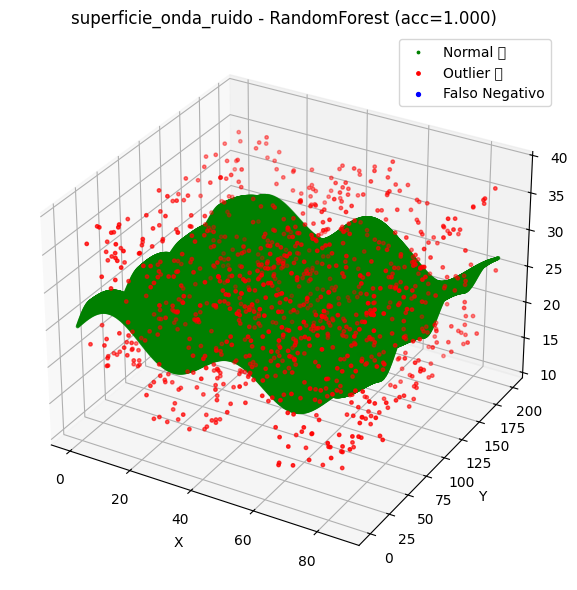


-> Modelo: ExtraTrees  |  Acurácia: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      0.99      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    8   992]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_onda_ruido_ExtraTrees.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


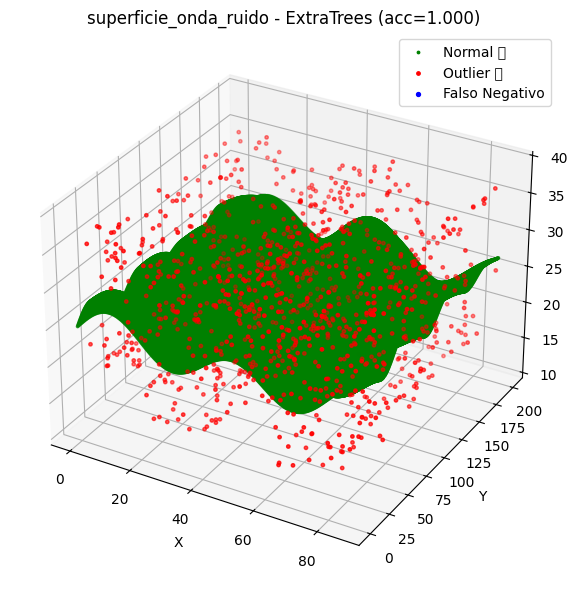


-> Modelo: GradientBoosting  |  Acurácia: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       0.99      1.00      0.99      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98966     7]
 [    4   996]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_onda_ruido_GradientBoosting.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


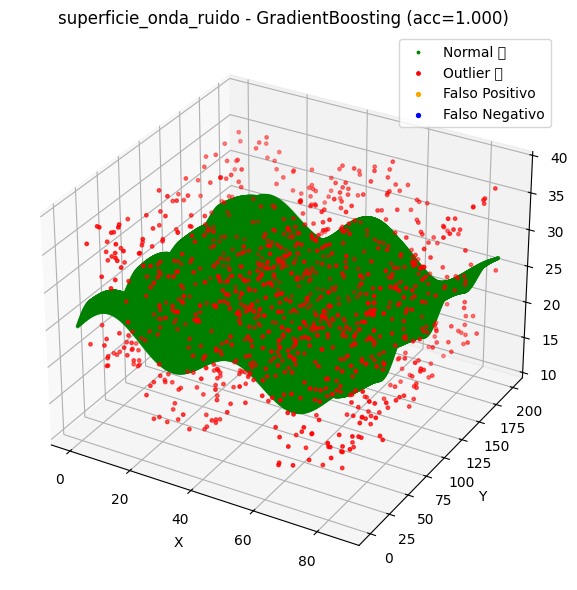


-> Modelo: MLP  |  Acurácia: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      0.98      0.99      1000

    accuracy                           1.00     99973
   macro avg       1.00      0.99      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98971     2]
 [   15   985]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_onda_ruido_MLP.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


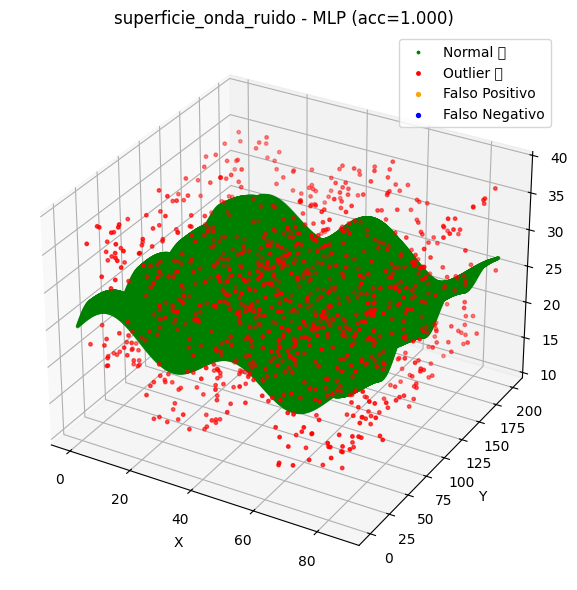



===== Avaliando nuvem: superficie_pico_ruido.txt =====

-> Modelo: RandomForest  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    3   997]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_pico_ruido_RandomForest.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


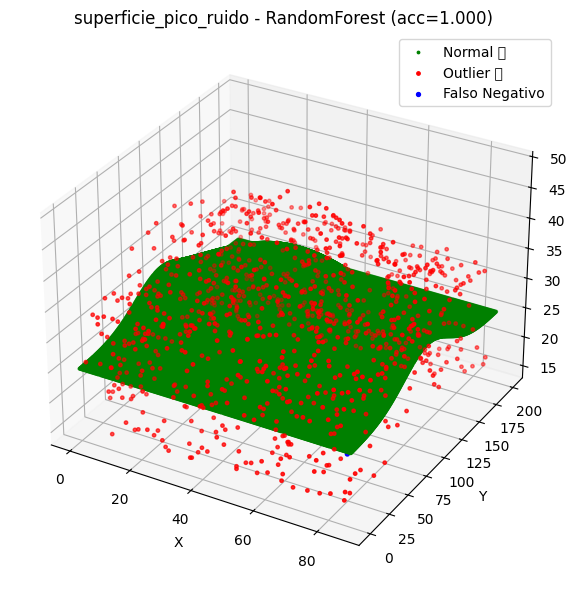


-> Modelo: ExtraTrees  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    4   996]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_pico_ruido_ExtraTrees.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


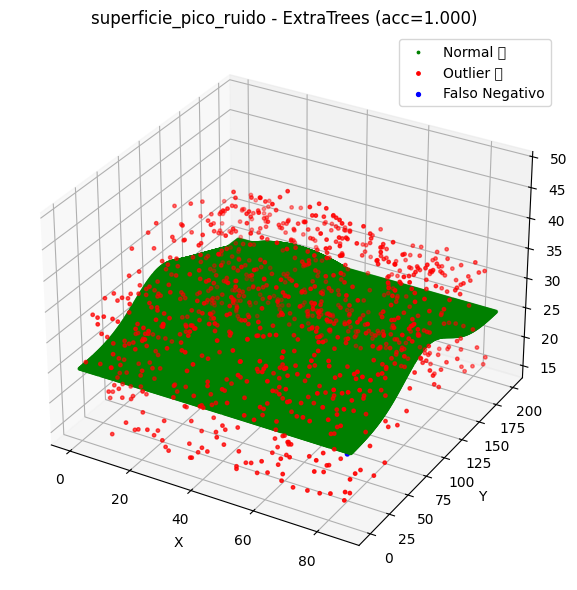


-> Modelo: GradientBoosting  |  Acurácia: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       0.99      1.00      0.99      1000

    accuracy                           1.00     99973
   macro avg       0.99      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98958    15]
 [    4   996]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_pico_ruido_GradientBoosting.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


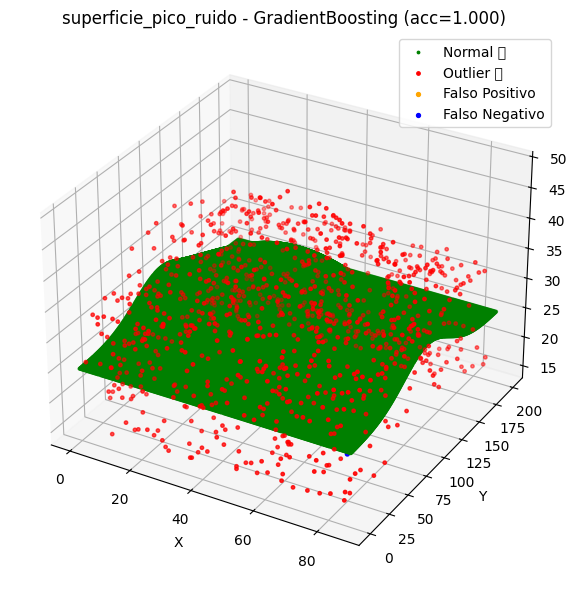


-> Modelo: MLP  |  Acurácia: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      0.98      0.99      1000

    accuracy                           1.00     99973
   macro avg       1.00      0.99      0.99     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [   21   979]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_pico_ruido_MLP.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


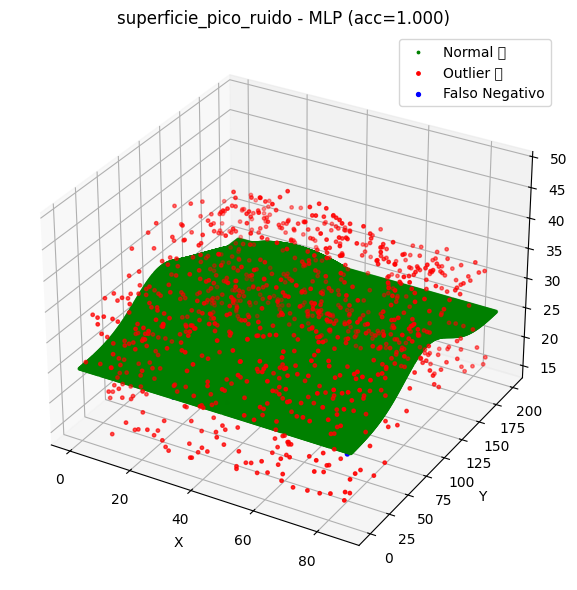



===== Avaliando nuvem: superficie_pico_suavizada_ruido.txt =====

-> Modelo: RandomForest  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    2   998]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_pico_suavizada_ruido_RandomForest.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


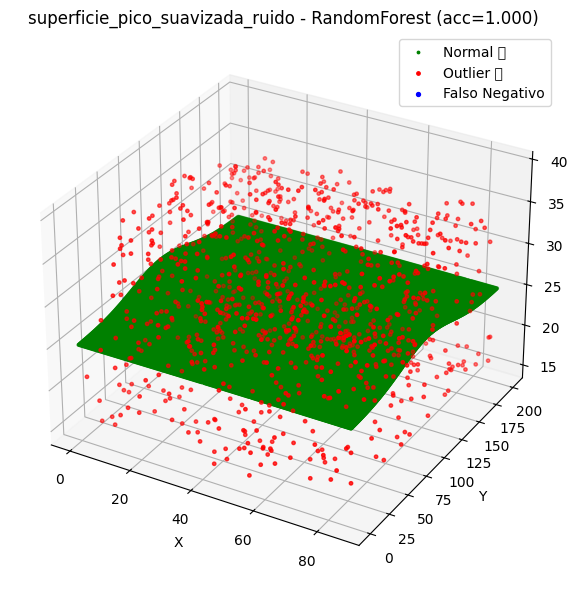


-> Modelo: ExtraTrees  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    3   997]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_pico_suavizada_ruido_ExtraTrees.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


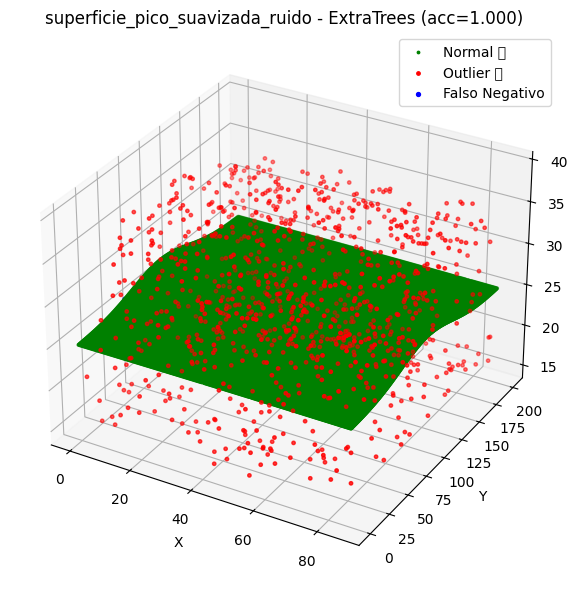


-> Modelo: GradientBoosting  |  Acurácia: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       0.98      1.00      0.99      1000

    accuracy                           1.00     99973
   macro avg       0.99      1.00      0.99     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98953    20]
 [    1   999]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_pico_suavizada_ruido_GradientBoosting.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


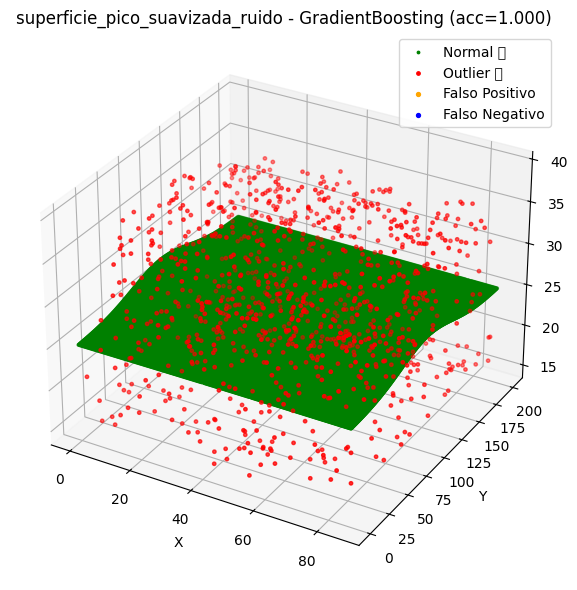


-> Modelo: MLP  |  Acurácia: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      0.99      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    9   991]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_pico_suavizada_ruido_MLP.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


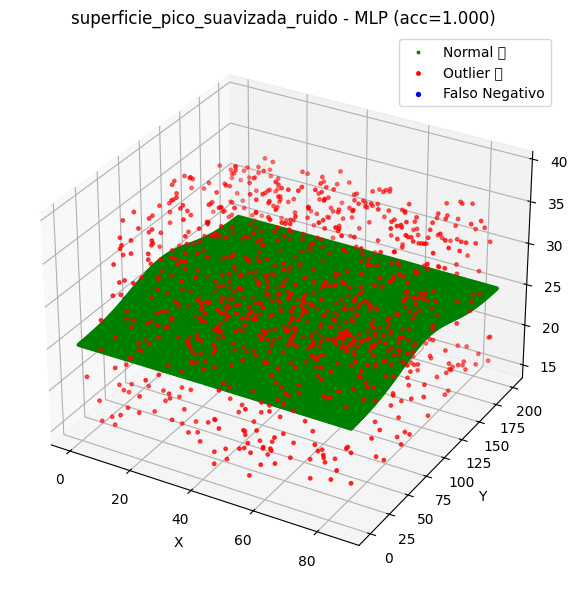



===== Avaliando nuvem: superficie_plano_ruido.txt =====

-> Modelo: RandomForest  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    1   999]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_plano_ruido_RandomForest.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


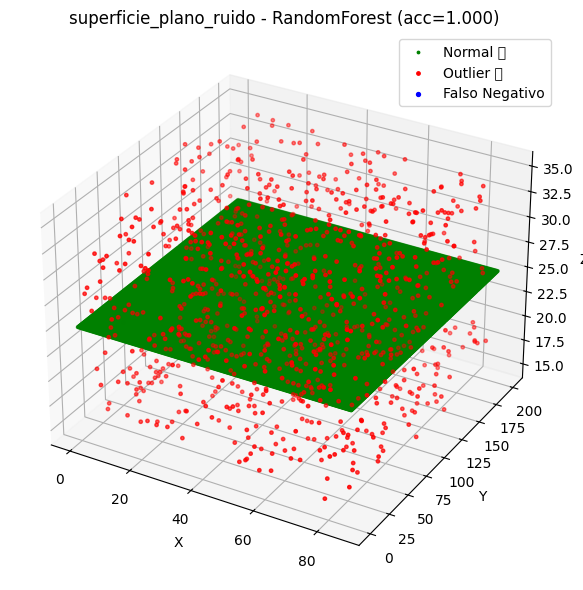


-> Modelo: ExtraTrees  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    1   999]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_plano_ruido_ExtraTrees.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


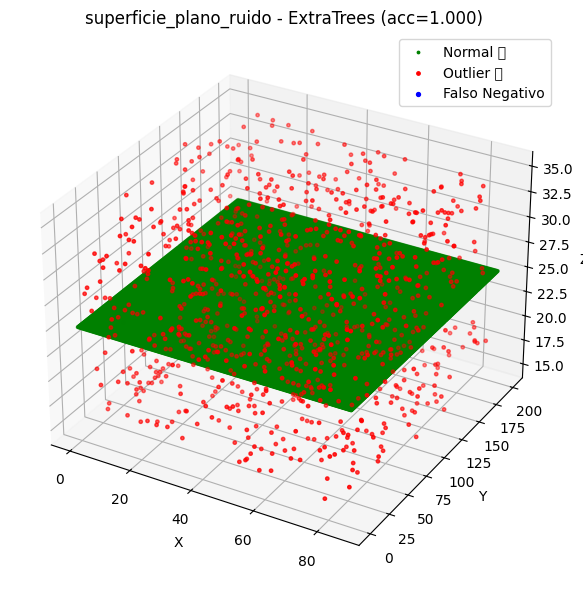


-> Modelo: GradientBoosting  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    1   999]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_plano_ruido_GradientBoosting.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


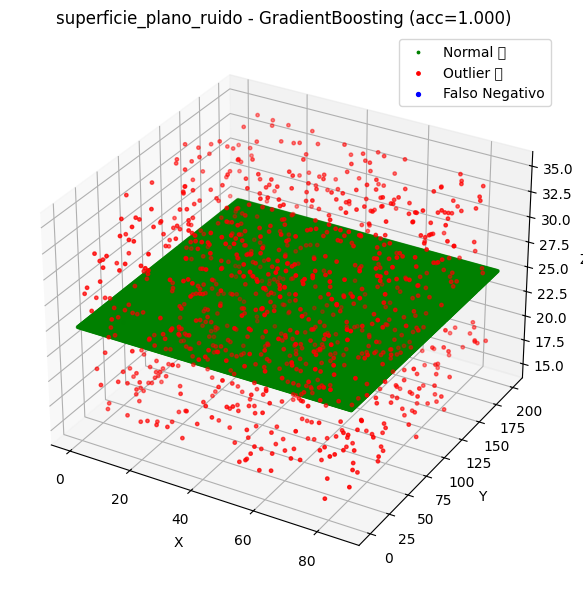


-> Modelo: MLP  |  Acurácia: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      0.99      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    7   993]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_plano_ruido_MLP.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


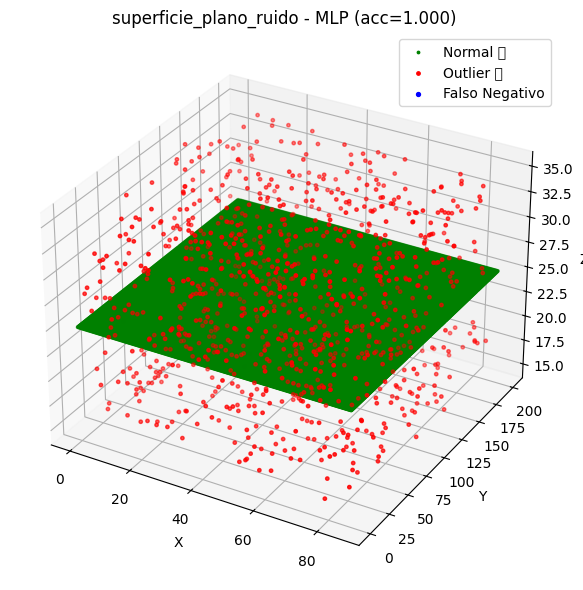



===== Avaliando nuvem: superficie_sela_ruido.txt =====

-> Modelo: RandomForest  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    0  1000]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_sela_ruido_RandomForest.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


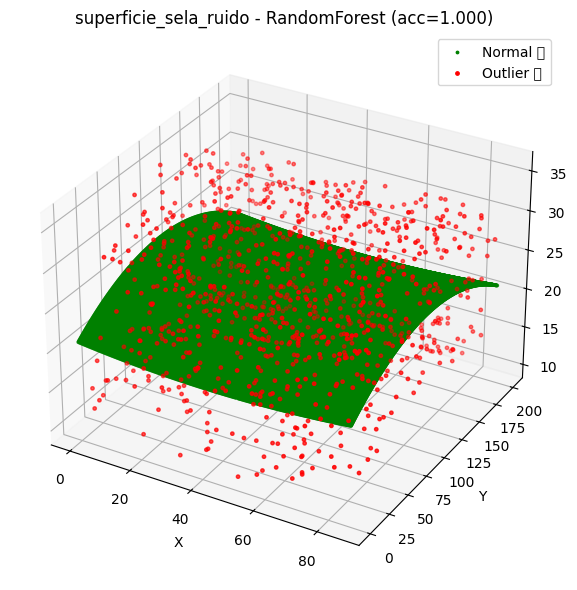


-> Modelo: ExtraTrees  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    2   998]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_sela_ruido_ExtraTrees.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


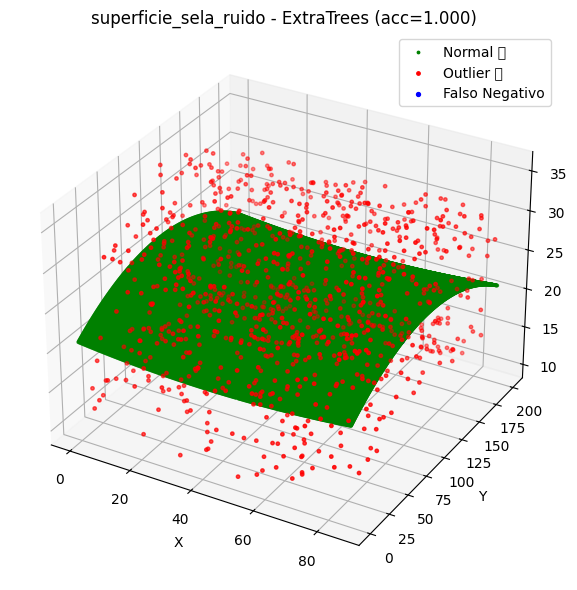


-> Modelo: GradientBoosting  |  Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98972     1]
 [    1   999]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_sela_ruido_GradientBoosting.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


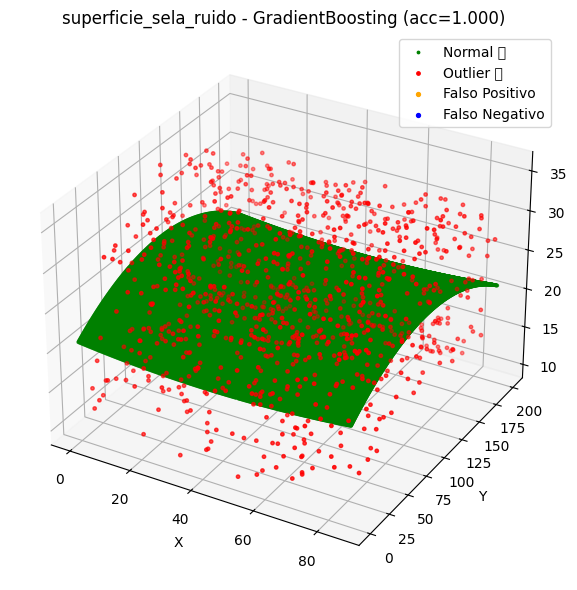


-> Modelo: MLP  |  Acurácia: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98973
           1       1.00      0.99      1.00      1000

    accuracy                           1.00     99973
   macro avg       1.00      1.00      1.00     99973
weighted avg       1.00      1.00      1.00     99973

Matriz de confusão:
[[98973     0]
 [    9   991]]


/tmp/ipython-input-272556522.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-272556522.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(outfig, dpi=200)


Plot salvo: results_pipeline/superficie_sela_ruido_MLP.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


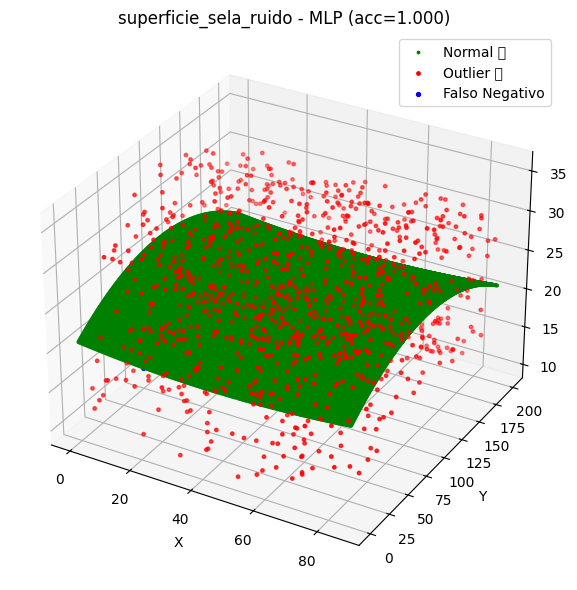

In [ ]:
# -----------------------------
# Avaliação separada por nuvem (usar o scaler treinado)
# -----------------------------
summary = []
for fname, feats in clouds_feats.items():
    print(f"\n\n===== Avaliando nuvem: {fname} =====")
    Xf = feats[feature_cols].fillna(0).values
    Xf_scaled = scaler.transform(Xf)
    yf = feats['label'].values
    n_points = len(feats)

    for mname, model in trained_models.items():
        yp = model.predict(Xf_scaled)
        acc = accuracy_score(yf, yp)
        crep = classification_report(yf, yp, zero_division=0)
        cm = confusion_matrix(yf, yp)
        print(f"\n-> Modelo: {mname}  |  Acurácia: {acc:.4f}")
        print(crep)
        print("Matriz de confusão:")
        print(cm)
        summary.append({'file': fname, 'model': mname, 'accuracy': acc, 'confusion': cm})

        # ----- Plot 3D de TP/TN/FP/FN -----
        # prepara df de visualização
        vis = feats[['x','y','z','label']].copy()
        vis['pred'] = yp
        tp = vis[(vis['label']==1) & (vis['pred']==1)]
        tn = vis[(vis['label']==0) & (vis['pred']==0)]
        fp = vis[(vis['label']==0) & (vis['pred']==1)]
        fn = vis[(vis['label']==1) & (vis['pred']==0)]

        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        if len(tn): ax.scatter(tn['x'], tn['y'], tn['z'], c='green', s=3, label='Normal ✅')
        if len(tp): ax.scatter(tp['x'], tp['y'], tp['z'], c='red', s=6, label='Outlier ✅')
        if len(fp): ax.scatter(fp['x'], fp['y'], fp['z'], c='orange', s=8, label='Falso Positivo')
        if len(fn): ax.scatter(fn['x'], fn['y'], fn['z'], c='blue', s=8, label='Falso Negativo')
        ax.set_title(f"{os.path.splitext(fname)[0]} - {mname} (acc={acc:.3f})")
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        ax.legend(loc='upper right')
        plt.tight_layout()

        if SAVE_PLOTS:
            outfig = os.path.join(OUT_FOLDER, f"{os.path.splitext(fname)[0]}_{mname}.png")
            plt.savefig(outfig, dpi=200)
            print(f"Plot salvo: {outfig}")
        if PLOT_SHOW:
            plt.show()
        plt.close(fig)

In [ ]:
  # -----------------------------
# Resumo final
# -----------------------------
df_summary = pd.DataFrame(summary)
print("\n\n=== Resumo final por arquivo e modelo ===")
print(df_summary.groupby(['file','model'])['accuracy'].mean().unstack(fill_value=0))
print(f"\nFiguras e resultados salvos em: {OUT_FOLDER}")



=== Resumo final por arquivo e modelo ===
model                                ExtraTrees  GradientBoosting      MLP  \
file                                                                         
superficie_onda_ruido.txt               0.99992           0.99989  0.99983   
superficie_pico_ruido.txt               0.99996           0.99981  0.99979   
superficie_pico_suavizada_ruido.txt     0.99997           0.99979  0.99991   
superficie_plano_ruido.txt              0.99999           0.99999  0.99993   
superficie_sela_ruido.txt               0.99998           0.99998  0.99991   

model                                RandomForest  
file                                               
superficie_onda_ruido.txt                 0.99996  
superficie_pico_ruido.txt                 0.99997  
superficie_pico_suavizada_ruido.txt       0.99998  
superficie_plano_ruido.txt                0.99999  
superficie_sela_ruido.txt                 1.00000  

Figuras e resultados salvos em: results_pipe

In [ ]:
import joblib

joblib.dump(trained_models['RandomForest'], "random_forest_model.pkl")
joblib.dump(trained_models['ExtraTrees'], "extra_trees_model.pkl")
joblib.dump(trained_models['GradientBoosting'], "gradient_boosting_model.pkl")
joblib.dump(trained_models['MLP'], "mlp_model.pkl")

print("Modelos salvos!")

Modelos salvos!


In [ ]:
import joblib

rf = joblib.load("random_forest_model.pkl")
et = joblib.load("extra_trees_model.pkl") # Assuming 'svm' was meant to be ExtraTrees
gb = joblib.load("gradient_boosting_model.pkl") # Assuming 'knn' was meant to be GradientBoosting
mlp = joblib.load("mlp_model.pkl")

print("Modelos carregados!")

Modelos carregados!


In [ ]:
# ================================
# IMPORTAR NUVEM REAL EM UMA ÚNICA CÉLULA
# ================================

import pandas as pd
from google.colab import files
import os

print("📂 Faça upload do arquivo da nuvem real (.txt)")
uploaded = files.upload()

# Encontrar automaticamente o arquivo .txt enviado
arquivo_txt = None
for arq in uploaded.keys():
    if arq.lower().endswith(".txt"):
        arquivo_txt = arq
        break

if arquivo_txt is None:
    raise ValueError("Nenhum arquivo .txt foi enviado!")

print(f"✔ Arquivo detectado: {arquivo_txt}")

# Verificar se possui cabeçalho
with open(arquivo_txt, 'r') as f:
    primeira_linha = f.readline().strip()

tem_header = any(col in primeira_linha.lower() for col in ["x", "y", "z", "label"])

if tem_header:
    print("✔ Cabeçalho detectado — lendo normalmente")
    df_real = pd.read_csv(arquivo_txt, sep=r"\s+")
else:
    print("⚠ Sem cabeçalho — adicionando nomes x y z label")
    df_real = pd.read_csv(arquivo_txt, sep=r"\s+", header=None, names=["x","y","z","label"])

print("\nPrévia da nuvem carregada:")
display(df_real.head())

# Criar X_real e y_real
X_real = df_real[["x","y","z"]].values
y_real = df_real["label"].values

print("\n✔ Dados prontos para o modelo!")
print("Formato X_real:", X_real.shape)
print("Formato y_real:", y_real.shape)


📂 Faça upload do arquivo da nuvem real (.txt)


Saving ITALO_nuvem_c_outlier.txt to ITALO_nuvem_c_outlier (3).txt
✔ Arquivo detectado: ITALO_nuvem_c_outlier (3).txt
✔ Cabeçalho detectado — lendo normalmente

Prévia da nuvem carregada:


x           y       z  label
0  735100.84  7675177.14  0.0000      0
1  735101.37  7675178.36  2.2162      1
2  735101.75  7675179.66  0.0000      0
3  735100.49  7675179.65  0.0000      0
4  735099.62  7675181.92  1.4918      1


✔ Dados prontos para o modelo!
Formato X_real: (1444, 3)
Formato y_real: (1444,)


In [ ]:
# ===========================================
# RODAR OS 4 MODELOS NA NUVEM REAL + VALIDAR
# ===========================================

import joblib
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Feature extraction and scaling for X_real (to match training data) ---
print("🔍 Extraindo features da nuvem real para predição...")
df_real_feats = extract_features_for_cloud(df_real)

# Select the feature columns and scale them using the pre-fitted scaler
X_real_processed = scaler.transform(df_real_feats[feature_cols].fillna(0).values)

# Keep y_real as is, as it's already the ground truth labels

# Lista de modelos para carregar e testar (atualizado para os modelos realmente salvos)
modelos = {
    "RandomForest": "random_forest_model.pkl",
    "ExtraTrees": "extra_trees_model.pkl",
    "GradientBoosting": "gradient_boosting_model.pkl",
    "MLP": "mlp_model.pkl"
}

def ajustar_predicoes(modelo_nome, y_pred):
    """
    Ajusta as predições para o padrão:
    1 = OUTLIER
    0 = NORMAL
    """

    # Para estes modelos, 0 e 1 já são os valores esperados
    return y_pred


# Rodar cada modelo
for nome, arquivo in modelos.items():

    print("\n=============================================")
    print(f"⭐ MODELO: {nome}")
    print("=============================================")

    # Carregar o modelo
    model = joblib.load(arquivo)

    # Gerar predições usando os dados X_real_processed
    y_pred = model.predict(X_real_processed)

    # Ajustar rótulos para 0/1 (para os modelos listados, não é necessário ajuste)
    y_pred_adj = ajustar_predicoes(nome, y_pred)

    # Matriz de confusão
    print("\n📌 Matriz de confusão:")
    print(confusion_matrix(y_real, y_pred_adj))

    # Relatório
    print("\n📌 Relatório de classificação:")
    print(classification_report(y_real, y_pred_adj, digits=3, zero_division=0))


🔍 Extraindo features da nuvem real para predição...

⭐ MODELO: RandomForest

📌 Matriz de confusão:
[[1323   21]
 [  33   67]]

📌 Relatório de classificação:
              precision    recall  f1-score   support

           0      0.976     0.984     0.980      1344
           1      0.761     0.670     0.713       100

    accuracy                          0.963      1444
   macro avg      0.869     0.827     0.846      1444
weighted avg      0.961     0.963     0.961      1444


⭐ MODELO: ExtraTrees

📌 Matriz de confusão:
[[546 798]
 [  5  95]]

📌 Relatório de classificação:
              precision    recall  f1-score   support

           0      0.991     0.406     0.576      1344
           1      0.106     0.950     0.191       100

    accuracy                          0.444      1444
   macro avg      0.549     0.678     0.384      1444
weighted avg      0.930     0.444     0.550      1444


⭐ MODELO: GradientBoosting

📌 Matriz de confusão:
[[1322   22]
 [  37   63]]

📌 Relatório

# Avaliação dos modelos:
# ====
# RANDON FOREST
# Identificou 98.4% dos pontos normais (classe 0).
# Identificou 67% dos outliers (classe 1).
# F1-score geral: 0.96 → excelente!
# =====
# EXTRATREES
# O modelo praticamente confundiu a classe 0, achando outlier em tudo.
# A recall da classe 1 é muito alta (0.95), mas classifica tudo como outilier
# A precisão da classe 1 é péssima (0.106)
# =====
# GRADIENTE BOOSTING
# Muito parecido com o RandomForest
# Ligeiramente pior na recall da classe 1 (0.63)
# Excelente para classe 0 (98.4%).
# =====
# MPL (rede neural)
# Excelente para classe 0 (98.4%).
# Recall da classe 1 = 0.56, indentificou captou poucos outliers
# F1 score da classe 1 = 0.39 (ruim)
# =====
# Conclusão: O melhor desempenho foi o RF muito proximo do GXboost, os outros dois foram muito ruins.


In [ ]:
import joblib

# Assuming X_real, y_real are available from previous cells (pdJqIQx7HSxG)
# X_real is the raw x, y, z coordinates
# y_real is the ground truth labels

# Lista de modelos (redefinida aqui para garantir acesso)
modelos = {
    "RandomForest": "random_forest_model.pkl",
    "ExtraTrees": "extra_trees_model.pkl",
    "GradientBoosting": "gradient_boosting_model.pkl",
    "MLP": "mlp_model.pkl"
}

# Loop para gerar e plotar resultados para cada modelo
for nome, arquivo in modelos.items():
    print(f"\nGerando plot 3D para o modelo: {nome}...")

    # Carregar o modelo
    model = joblib.load(arquivo)

    # Gerar predições usando os dados X_real_processed (que foi usado para a avaliação)
    # X_real_processed e y_real são do passo de avaliação anterior (Q_sY1iQaH-4u)
    y_pred = model.predict(X_real_processed)

    # Como ajustamos a função 'ajustar_predicoes' para retornar y_pred diretamente para esses modelos,
    # y_pred_adj é simplesmente y_pred.
    y_pred_adj = y_pred

    # Chamar a função de plotagem com os dados originais (X_real) e as predições
    plot_3d_results(nome, X_real, y_real, y_pred_adj)

print("Plots 3D gerados para todos os modelos!")


Gerando plot 3D para o modelo: RandomForest...



Gerando plot 3D para o modelo: ExtraTrees...



Gerando plot 3D para o modelo: GradientBoosting...



Gerando plot 3D para o modelo: MLP...


Plots 3D gerados para todos os modelos!
